In [1]:
import os 
import os.path
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
PATH = "./images_for_model"
image_urls=[os.path.join(PATH, image) for image in os.listdir(PATH)]

In [3]:
img_example= cv2.imread(image_urls[0], cv2.IMREAD_UNCHANGED)

In [15]:
scale_percent = 10 #1 percent of original size
width = int(img_example.shape[1] * scale_percent / 100)
height = int(img_example.shape[0] * scale_percent / 100)
dim = (width, height)

In [16]:
images_resized=[cv2.resize(cv2.imread(image_url, cv2.IMREAD_UNCHANGED), dim, interpolation = cv2.INTER_AREA) for image_url in image_urls]

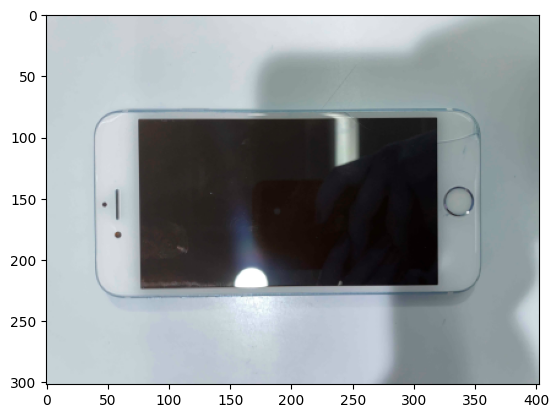

In [17]:
plt.imshow(images_resized[0])
plt.show()

In [18]:
image_array=np.array([cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB) for image_resized in images_resized])

In [19]:
image_labels=np.array([image_url.split('/')[-1].split('_')[1] for image_url in image_urls])

In [20]:
import re
image_labels_final=np.array([ 'working' if bool(re.search('.jpeg$', image_label)) else image_label for image_label in image_labels])

In [29]:
np.unique(image_labels_final)

array(['crack', 'crackandlcd', 'lcd', 'working'], dtype='<U11')

In [31]:
image_labels_final[image_labels_final == 'working'] = 0
image_labels_final[image_labels_final == 'crack'] = 1
image_labels_final[image_labels_final == 'lcd'] = 2
image_labels_final[image_labels_final == 'crackandlcd'] = 3

In [55]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_array, image_labels_final, test_size=0.3, random_state=4)

In [56]:
y_train=y_train.astype(int)
y_test=y_test.astype(int)

In [57]:
mu = X_train.mean(axis=(0,1,2)) # finds mean of R, G and B separately
std = X_train.std(axis=(0,1,2)) # same for std
X_train_norm = (X_train - mu)/std
X_test_norm = (X_test - mu)/std

In [58]:
class KNearestNeighbor(object):
    def __init__(self):
        pass
    def train(self, X, y):
        self.X_train = X
        self.y_train = y
        
    def predict(self, X, k=1, num_loops=0):
        if num_loops == 0:
            dists = self.compute_distances(X)
        else:
            raise ValueError('Invalid value %d for num_loops' % num_loops)
        return self.predict_labels(dists, k=k)


    def compute_distances(self, X):
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train)) 
        dists = np.sqrt(np.sum(np.square(self.X_train), axis=1) + np.sum(np.square(X), axis=1)[:, np.newaxis] - 2 * np.dot(X, self.X_train.T))
        pass
        return dists

    def predict_labels(self, dists, k=1):
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)
        for i in range(num_test):
            closest_y = []
            sorted_dist = np.argsort(dists[i])
            closest_y = list(self.y_train[sorted_dist[0:k]])
            pass
            y_pred[i]= np.argmax(np.bincount(closest_y))
            pass
        return y_pred

In [59]:
image_array.shape

(252, 302, 403, 3)

In [60]:
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(176, 365118) (76, 365118)


In [62]:
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
dists= classifier.compute_distances(X_test)
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
num_test=X_test.shape[0]
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 36 / 76 correct => accuracy: 0.473684


In [63]:
print(y_test_pred)
print(y_test)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
[0 1 0 0 0 0 2 0 1 0 0 1 0 0 1 1 1 0 1 1 1 0 0 0 0 1 1 0 0 1 0 1 1 1 0 0 1
 1 1 1 1 0 0 0 2 0 0 1 1 2 2 0 1 0 1 1 1 0 0 0 0 0 1 1 0 2 1 2 1 1 1 1 1 0
 0 0]


In [64]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []

X_train_folds = np.array_split(X_train,num_folds)
y_train_folds = np.array_split(y_train,num_folds)
k_to_accuracies = {}



for k in k_choices:
    k_to_accuracies[k] = []
    for num_knn in range(0,num_folds):
        X_test = X_train_folds[num_knn]
        y_test = y_train_folds[num_knn]
        X_train = X_train_folds
        y_train = y_train_folds
        
        temp = np.delete(X_train,num_knn,0)
        X_train = np.concatenate((temp),axis = 0)
        y_train = np.delete(y_train,num_knn,0)
        y_train = np.concatenate((y_train),axis = 0)
        
        classifier = KNearestNeighbor()
        classifier.train(X_train, y_train)
        dists = classifier.compute_distances(X_test)
        y_test_pred = classifier.predict_labels(dists, k)

        num_correct = np.sum(y_test_pred == y_test)
        accuracy = float(num_correct) / num_test
#         print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))
        k_to_accuracies[k].append(accuracy)


print("Printing our 5-fold accuracies for varying values of k:")
print()
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

/gpfs/space/home/kozlovsk/venvs/foxway_env/lib/python3.9/site-packages/numpy/lib/function_base.py:5071: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


Printing our 5-fold accuracies for varying values of k:

k = 1, accuracy = 0.013158
k = 1, accuracy = 0.236842
k = 1, accuracy = 0.223684
k = 1, accuracy = 0.236842
k = 1, accuracy = 0.210526
k = 3, accuracy = 0.263158
k = 3, accuracy = 0.236842
k = 3, accuracy = 0.223684
k = 3, accuracy = 0.236842
k = 3, accuracy = 0.210526
k = 5, accuracy = 0.263158
k = 5, accuracy = 0.236842
k = 5, accuracy = 0.223684
k = 5, accuracy = 0.236842
k = 5, accuracy = 0.210526
k = 8, accuracy = 0.263158
k = 8, accuracy = 0.236842
k = 8, accuracy = 0.223684
k = 8, accuracy = 0.236842
k = 8, accuracy = 0.210526
k = 10, accuracy = 0.263158
k = 10, accuracy = 0.236842
k = 10, accuracy = 0.223684
k = 10, accuracy = 0.236842
k = 10, accuracy = 0.210526
k = 12, accuracy = 0.263158
k = 12, accuracy = 0.236842
k = 12, accuracy = 0.223684
k = 12, accuracy = 0.236842
k = 12, accuracy = 0.210526
k = 15, accuracy = 0.263158
k = 15, accuracy = 0.236842
k = 15, accuracy = 0.223684
k = 15, accuracy = 0.236842
k = 15, acc